## Problem Description
The problem we are going to look at in this post is the International Airline Passengers prediction problem.

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout


In [2]:
dataset = pd.read_csv('airline-passengers.csv')
dataset.head() # But we don't want data in this way, as the month is a string and cannot be converted to float

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [16]:
# load the dataset as per our requirements
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [17]:
dataframe.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [20]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB


Text(0,0.5,'No. of passengers')

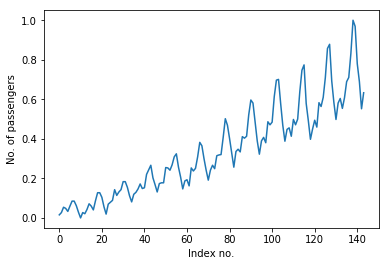

In [21]:
plt.plot(dataset)
plt.xlabel('Index no.')
plt.ylabel('No. of passengers')

## LSTM Network for Regression
We can phrase the problem as a regression problem. - That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

* We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the *MinMaxScaler* preprocessing class from the *scikit-learn library*.

In [19]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [22]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [25]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Let’s take a look at the effect of this function on the first rows of the dataset (shown in the unnormalized form for clarity).

X		Y
112		118
118		132
132		129
129		121
121		135

If you compare these first 5 rows to the original dataset sample listed in the previous section, you can see the X=t and Y=t+1 pattern in the numbers.

Let’s use this function to prepare the train and test datasets for modeling.

In [26]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

**<font color='green'>The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].</font>**

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using *numpy.reshape()* as follows:

In [38]:
print(trainX.shape[0],trainX.shape[1])

94 1


In [28]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Model -
We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [29]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0216
Epoch 2/100
 - 0s - loss: 0.0103
Epoch 3/100
 - 0s - loss: 0.0090
Epoch 4/100
 - 0s - loss: 0.0080
Epoch 5/100
 - 0s - loss: 0.0072
Epoch 6/100
 - 0s - loss: 0.0065
Epoch 7/100
 - 0s - loss: 0.0057
Epoch 8/100
 - 0s - loss: 0.0050
Epoch 9/100
 - 0s - loss: 0.0043
Epoch 10/100
 - 0s - loss: 0.0038
Epoch 11/100
 - 0s - loss: 0.0033
Epoch 12/100
 - 0s - loss: 0.0029
Epoch 13/100
 - 0s - loss: 0.0027
Epoch 14/100
 - 0s - loss: 0.0025
Epoch 15/100
 - 0s - loss: 0.0022
Epoch 16/100
 - 0s - loss: 0.0022
Epoch 17/100
 - 0s - loss: 0.0021
Epoch 18/100
 - 0s - loss: 0.0021
Epoch 19/100
 - 0s - loss: 0.0020
Epoch 20/100
 - 0s - loss: 0.0020
Epoch 21/100
 - 0s - loss: 0.0020
Epoch 22/100
 - 0s - loss: 0.0020
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0020
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0020
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

In [30]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

NOTE - We invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month)

In [32]:
# invert predictions as they would have come had we not normalized the data
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [33]:
testPredict

array([[306.8075 ],
       [293.92413],
       [343.89038],
       [336.73898],
       [342.9989 ],
       [401.0226 ],
       [436.19626],
       [437.78925],
       [385.79657],
       [335.84198],
       [297.61508],
       [325.9319 ],
       [329.5446 ],
       [309.55493],
       [349.22467],
       [336.73898],
       [350.11118],
       [411.83926],
       [456.59448],
       [467.29562],
       [385.79657],
       [346.56073],
       [302.2177 ],
       [326.83597],
       [347.44943],
       [331.3471 ],
       [387.50226],
       [378.93982],
       [399.34497],
       [441.7543 ],
       [498.89746],
       [506.6712 ],
       [434.59946],
       [388.35385],
       [349.22467],
       [386.64978],
       [396.8217 ],
       [374.6273 ],
       [398.50476],
       [432.99866],
       [441.7543 ],
       [489.5466 ],
       [548.7523 ],
       [538.45715],
       [469.56262],
       [432.99866]], dtype=float32)

In [36]:
# calculate root mean squared error
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.93 RMSE
Test Score: 51.77 RMSE


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


We can see that the model has an average error of about 23 passengers (in thousands) on the training dataset, and about 52 passengers (in thousands) on the test dataset. Not that bad.